# Pitch Filterbank

The goal of the pitch filterbank convert an audio signal into a time-frequency representation.
In comparison to the Short Time Fourier Transform (STFT), the bands of the pitch filterbank
mimic musical pitches on an equal tempered scale, i.e., each filter band has the bandwith of a semitone
and their center frequencies are also one semitone apart.

In [2]:
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import time
from IPython import display

%matplotlib inline

## Filterbank Generation

 * We generate 100 filters ranging from Midi pitches 21-120.
 * Each filter is designed using elliptic filters.
 * The stopband rejection should be -50 dB.
 * The maximum passband ripple is 1 dB.
 * The quality factor (Q) of each filter is 25.

In [3]:
midi_start = 21
midi_pitches = np.arange(midi_start, 121)
center_freqs = librosa.core.midi_to_hz(midi_pitches)

In [4]:
passband_ripple = 1 # in dB
stopband_attenuation = 50 # in dB
Q = 25

In [5]:
sample_rates = np.zeros_like(center_freqs)
sample_rates[21 - midi_start:60 - midi_start] = 882
sample_rates[60 - midi_start:95 - midi_start] = 4410
sample_rates[95 - midi_start:] = 22050
nyquist = sample_rates / 2
filter_bandwidths = center_freqs / Q

In [6]:
pitch_filterbank = []

for cur_center_freq, cur_sr, cur_nyquist, cur_bw in zip(center_freqs, sample_rates, nyquist, filter_bandwidths):
    passband_freqs = [cur_center_freq - cur_bw / 2, cur_center_freq + cur_bw / 2] / cur_sr
    stopband_freqs = [cur_center_freq - cur_bw, cur_center_freq + cur_bw] / cur_sr

    # get the order of the elliptic filter and the normalized freqs
    cur_order, cur_freqs = scipy.signal.ellipord(passband_freqs, stopband_freqs,
                                                 passband_ripple, stopband_attenuation)

    # generate the elliptic filter
    cur_filter = scipy.signal.ellip(cur_order, passband_ripple, stopband_attenuation,
                                    cur_freqs, btype='bandpass')

    pitch_filterbank.append(cur_filter)

## Visualization

We can plot the magnitude response of each filter. You can see the effect of the constant Q factor:
The lower the center frequency of the filter gets, the smaller its bandwith, and thus more frequency selective.

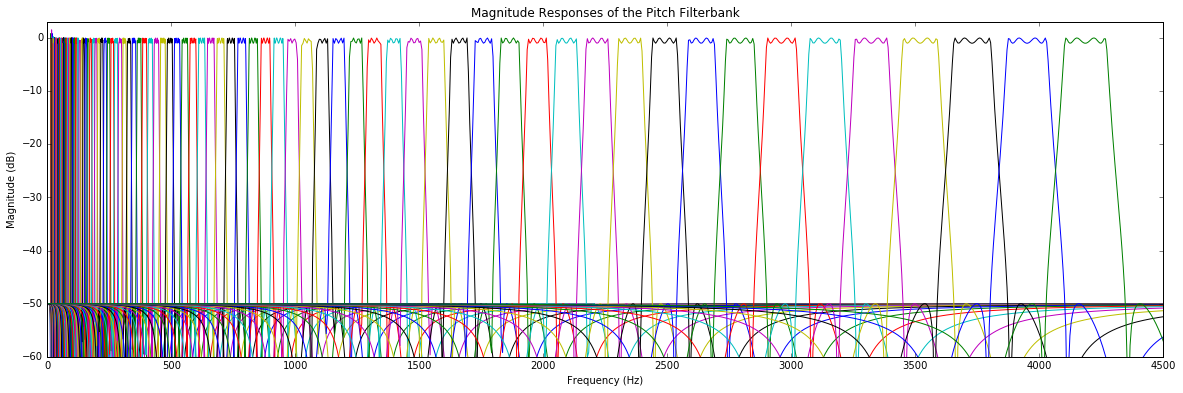

In [170]:
plt.figure(figsize=(20,6))

for cur_sr, cur_filter in zip(sample_rates, pitch_filterbank):
    w, h = scipy.signal.freqz(cur_filter[0], cur_filter[1], worN=2000)
    plt.plot((cur_sr / (2 * np.pi)) * w, 20 * np.log10(abs(h)))

    # display.display(plt.gcf())
    # display.clear_output(wait=True)
    # time.sleep(0.01)
    plt.xlim([0, 4500])
    plt.ylim([-60, 3])

plt.title('Magnitude Responses of the Pitch Filterbank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

## Process Audio

In [14]:
y = dict()
y[22050], fs = librosa.load('../data/Systematic_Scale-C-Major_Meinard_fast.wav')
y[4410] = librosa.resample(y_22050, fs, 4410)
y[882] = librosa.resample(y_22050, fs, 882)

In [151]:
# short-time mean-square power
win_length_STMSP = dict()
win_length_STMSP[22050] = 4410
win_length_STMSP[4410] = np.round(win_length_STMSP[22050] / 5)
win_length_STMSP[882] = np.round(win_length_STMSP[22050] / 25)

hop_size_STMSP = dict()
hop_size_STMSP[22050] = np.round(win_length_STMSP[22050] / 2)
hop_size_STMSP[4410] = np.round(win_length_STMSP[4410] / 2)
hop_size_STMSP[882] = np.round(win_length_STMSP[882] / 2)

feature_rate = fs / hop_size_STMSP[22050]
feature_rate

10.0

In [153]:
pitch_energy = []

for cur_sr, cur_filter in zip(sample_rates, pitch_filterbank):
    # filter the signal
    cur_filter_output = scipy.signal.filtfilt(cur_filter[0], cur_filter[1], y[int(cur_sr)])

    # frame the current filter output
    cur_frames = librosa.util.frame(np.ascontiguousarray(cur_filter_output),
                                    frame_length=win_length_STMSP[int(cur_sr)],
                                    hop_length=hop_size_STMSP[int(cur_sr)])
    factor = fs / cur_sr

    pitch_energy.append(factor * np.sum(cur_frames**2, axis=0))

/Users/stibie/miniconda3/envs/py3/lib/python3.5/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


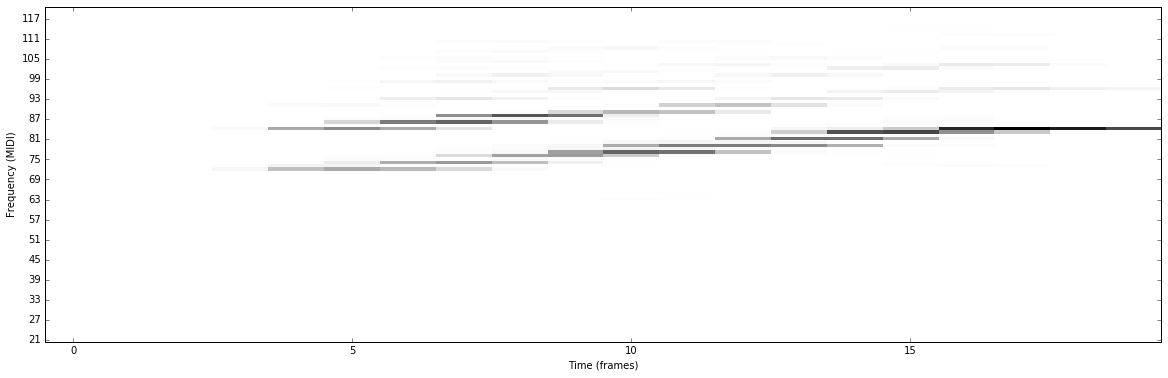

In [154]:
pitch_energy = np.asarray(pitch_energy)

plt.figure(figsize=(20,6))
plt.imshow(np.log(1 + 5 * pitch_energy), origin='lower', aspect='auto', interpolation='nearest',
           cmap=plt.cm.gray_r)
plt.yticks(np.arange(0, pitch_energy.shape[0], 6), np.arange(0, pitch_energy.shape[0], 6) + 21)
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (MIDI)')